In [5]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from scipy.spatial.distance import pdist, squareform
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt


In [6]:
def get_IT_tickers(sector):
    # URL for Stock Analysis's list of energy sector companies
    # url = f"https://stockanalysis.com/stocks/sector/{sector}/"
    url = f"https://stockanalysis.com/stocks/industry/{sector}/"
    # url = f"https://stockanalysis.com/stocks"

    response = requests.get(url)
    html_content = response.content

    soup = BeautifulSoup(html_content, "html.parser")
    ticker_elements = soup.select("td a") # .svelte-eurwtr
    tickers = [elem.text for elem in ticker_elements]

    return tickers

tickers = get_IT_tickers("information-technology-services")
print(tickers)

['ACN', 'IBM', 'FI', 'INFY', 'FIS', 'CTSH', 'IT', 'CDW', 'WIT', 'GIB', 'BR', 'LDOS', 'EPAM', 'JKHY', 'CACI', 'PSN', 'GLOB', 'SAIC', 'G', 'EXLS', 'CLVT', 'KD', 'AUR', 'ASGN', 'CNXC', 'DXC', 'NABL', 'WNS', 'VYX', 'GDS', 'PRFT', 'XRX', 'FORTY', 'TASK', 'NYAX', 'CNDT', 'GDYN', 'TWKS', 'HCKT', 'MGIC', 'VNET', 'DMRC', 'CTLP', 'BBAI', 'UIS', 'TTEC', 'IBEX', 'INOD', 'NOTE', 'III', 'CSPI', 'JFU', 'DTST', 'GMM', 'BTCM', 'ARBB', 'CLPS', 'WYY', 'CTM', 'WAVD']


In [7]:

def get_data_from_tickers(tickers):
    data_dict = {}

    for ticker in tickers:
        try:
            data = yf.download(ticker, start="2018-01-01", end="2018-06-01")

            if not data.empty:
                data_dict[ticker] = data['Adj Close']
        except:
            print(f"Error fetching data for {ticker}. Skipping.")

    combined_data = pd.DataFrame(data_dict)
    combined_data = combined_data.dropna(axis=1, how='all')
    combined_data.to_csv("stock_data_IT.csv")

    return combined_data

# Load the data from the CSV file
stock_data = pd.read_csv("stock_data_IT.csv", index_col=0)
stock_data.head()

,ACN,ASGN,BR,BTCM,CACI,CDW,CNDT,CSPI,CTLP,CTSH,...,SAIC,TTEC,UIS,VNET,VYX,WAVD,WIT,WNS,WYY,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,139.834549,63.360001,81.668030,107.500000,134.149994,64.948296,16.540001,5.839521,9.75,65.117874,...,69.789619,34.718552,8.35,8.42,21.380367,4.2,5.563962,39.869999,6.8,21.827318
2018-01-03,140.479935,63.110001,81.596077,114.400002,137.800003,66.847595,16.250000,5.473580,9.70,65.668556,...,69.636612,34.632179,8.35,9.00,21.521473,4.2,5.524984,39.400002,6.9,21.797586
2018-01-04,142.143356,64.190002,82.243652,114.400002,136.600006,68.020676,16.270000,5.644871,9.50,66.705711,...,70.158577,34.632179,8.60,8.97,20.907974,4.2,5.505496,39.139999,6.7,22.065134
2018-01-05,143.315918,65.250000,83.251015,116.900002,137.149994,67.908943,16.160000,5.578690,9.60,67.274742,...,70.185577,34.545818,8.55,9.16,21.165644,4.2,5.417798,39.689999,6.9,22.228636
2018-01-08,144.461212,67.940002,83.763687,118.500000,138.250000,68.011368,16.459999,5.866773,9.50,67.338989,...,70.806519,35.107185,8.65,9.14,21.766870,4.1,5.524984,40.689999,6.8,22.488749


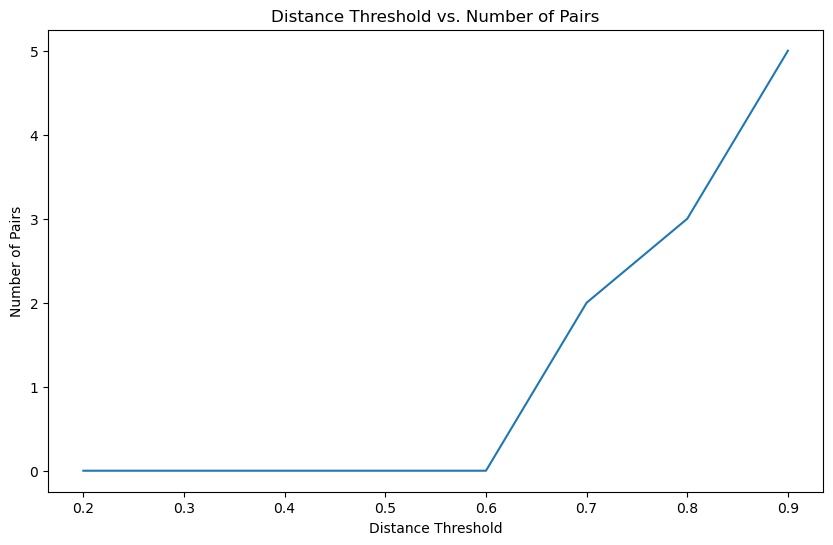

In [8]:
X = stock_data.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

distance_matrix = squareform(pdist(X_pca, metric='euclidean'))
thresholds = np.arange(0.2, 1.0, 0.1)
pairs_dict = {}

for threshold in thresholds:
    labels = (distance_matrix < threshold).astype(int)
    pairs = np.argwhere(np.triu(labels, k=1) == 1)
    pairs_dict[threshold] = pairs

plt.figure(figsize=(10, 6))
plt.plot(thresholds, [len(pairs) for pairs in pairs_dict.values()])
plt.xlabel('Distance Threshold')
plt.ylabel('Number of Pairs')
plt.title('Distance Threshold vs. Number of Pairs')
plt.show()

In [9]:
import pandas as pd
import numpy as np

data = pd.read_csv("stock_data_IT.csv")
data = data.select_dtypes(include=[np.number])


daily_returns = data.pct_change()
correlation_matrix = daily_returns.corr()
correlation_threshold = 0.7

high_corr_pairs = []
for col1 in correlation_matrix.columns:
  for col2 in correlation_matrix.columns:
    if col1 != col2 and correlation_matrix.loc[col1, col2] > correlation_threshold:
      high_corr_pairs.append((col1, col2))

print("Highly Correlated Stock Pairs:")
for pair in high_corr_pairs:
  print(f"{pair[0]} - {pair[1]}")


Highly Correlated Stock Pairs:
ACN - BR
ACN - CTSH
BR - ACN
BR - JKHY
CTSH - ACN
FIS - JKHY
JKHY - BR
JKHY - FIS


In [10]:
# Create trading bot with newly processed data
def runSim(stock1, stock2):
    interface = 0
    stocks = [stock1,stock2]
    start = '2019-12-31'
    end = '2021-03-08'
    fee = 0.001
    window = 252
    t_threshold = -2.5

    data = pd.DataFrame()
    returns = pd.DataFrame()
    for stock in stocks:
        prices = yf.download(stock, start, end)
        data[stock] = prices['Close']
        returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True) - 1 , 0)

    gross_returns = np.array([])
    net_returns = np.array([])
    t_s = np.array([])
    stock1 = stocks[0]
    stock2 = stocks[1]


    for t in range(window, len(data)):

        #defining the unit root function: stock2 = a + b*stock1
        def unit_root(b):
            a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t])
            fair_value = a + b*data[stock1][t-window:t]
            diff = np.array(fair_value - data[stock2][t-window:t])
            diff_diff = diff[1:] - diff[:-1]
            reg = sm.OLS(diff_diff, diff[:-1])
            res = reg.fit()
            return res.params[0]/res.bse[0]

        res1 = spop.minimize(unit_root, data[stock2][t]/data[stock1][t], method='Nelder-Mead')
        t_opt = res1.fun
        b_opt = float(res1.x)
        a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])

        # Trade SIm
        fair_value = a_opt + b_opt*data[stock1][t]
        if t == window:
            old_signal = 0
        if t_opt > t_threshold:
            signal = 0
            gross_return = 0
        else:
            signal = np.sign(fair_value - data[stock2][t])
            gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]
        fees = fee*abs(signal - old_signal)
        net_return = gross_return - fees
        gross_returns = np.append(gross_returns, gross_return)
        net_returns = np.append(net_returns, net_return)
        t_s = np.append(t_s, t_opt)

        # remove later
        if interface == 1:
            print('day '+str(data.index[t]))
            print('')
            if signal == 0:
                print('no trading')
            elif  signal == 1:
                print('long position on '+stock2+' and short position on '+stock1)
            else:
                print('long position on '+stock1+' and short position on '+stock2)
            print('gross daily return: '+str(round(gross_return*100,2))+'%')
            print('net daily return: '+str(round(net_return*100,2))+'%')
            print('cumulative net return so far: '+str(round(np.prod(1+net_returns)*100-100,2))+'%')
            print('')
        old_signal = signal



    return (np.append(1,np.cumprod(1+gross_returns))), (np.append(1,np.cumprod(1+net_returns)))

def plotSim(stock1, stock2):
    equity_curve_gross, equity_curve_net = runSim(stock1, stock2)
    plt.title('Pairs Profit')
    plt.plot(equity_curve_gross, label='gross returns')
    plt.plot(equity_curve_net, label='net returns')
    plt.legend()
    plt.show()

def net_equity(stock1,stock2):
    return (runSim(stock1,stock2)[1][-1] - 1) * 100

In [11]:
import warnings
warnings.filterwarnings("ignore", message="Conversion of an array with ndim > 0 to a scalar is deprecated...")

total = 0

for pair in high_corr_pairs:
    n_eq= net_equity(pair[0],pair[1])
    print(f" ROI is {n_eq} %")
    total += n_eq
print(f"Total ROI is {total} %")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is 2.758924638098259 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is 0.948848262958113 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is 2.758924638098259 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is 2.6225362469753266 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is 0.948848262958113 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is -6.460527635452262 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is -2.467494514280144 %


 ROI is 8.920862593567257 %
Total ROI is 10.030922492922922 %


In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  # Import tqdm

# Load stock price data
stock_data = pd.read_csv('stock_data.csv', index_col='Date')

# Calculate features (e.g., daily returns, technical indicators)
stock_data = stock_data.pct_change().dropna()
# stock_data = stock_data.join(other_features)  # Replace with your feature calculation

# Generate feature vectors for all stock pairs
pair_features = []
columns = list(range(len(stock_data.columns)))
for i in tqdm(columns):  # Wrap iterable with tqdm
    for j in range(i+1, len(stock_data.columns)):
        pair_features.append(stock_data.iloc[:, [i, j]].values)

100%|██████████| 296/296 [00:04<00:00, 60.47it/s] 


In [13]:
# Standardize the feature vectors
scaler = StandardScaler()
pair_features_scaled = scaler.fit_transform(np.vstack(pair_features))

# PCA transformation
pca = PCA(n_components=0.95)  # Retain 95% of variance
pair_features_pca = pca.fit_transform(pair_features_scaled)


In [40]:
from joblib import Parallel, delayed

# Split the dataset into chunks
chunk_size = 1000
n_chunks = len(pair_features_pca) // chunk_size

# Process each chunk in parallel
def process_chunk(chunk):
    dbscan = DBSCAN(eps=1.1, min_samples=1, metric='euclidean')
    return dbscan.fit_predict(chunk)

clusters = Parallel(n_jobs=-1)(delayed(process_chunk)(pair_features_pca[i:i+chunk_size]) for i in range(0, len(pair_features_pca), chunk_size))

# Combine the results
cluster_labels = np.concatenate(clusters)


In [41]:
# take the closest clusters
from scipy.spatial.distance import cdist

def get_closest_clusters(cluster_labels, pair_features_pca):
    cluster_centers = []
    for cluster in np.unique(cluster_labels):
        if cluster == -1:
            continue
        cluster_center = np.mean(pair_features_pca[cluster_labels == cluster], axis=0)
        cluster_centers.append(cluster_center)

    cluster_centers = np.vstack(cluster_centers)
    cluster_distances = cdist(cluster_centers, cluster_centers)
    np.fill_diagonal(cluster_distances, np.inf)

    closest_clusters = np.unravel_index(np.argmin(cluster_distances), cluster_distances.shape)
    return closest_clusters

closest_clusters = get_closest_clusters(cluster_labels, pair_features_pca)

# Find the stock pairs in the closest clusters
cluster1 = np.argwhere(cluster_labels == closest_clusters[0]).ravel()
cluster2 = np.argwhere(cluster_labels == closest_clusters[1]).ravel()

stock_pairs = []
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        if i in cluster1 and j in cluster1:
            stock_pairs.append((i, j))
        elif i in cluster2 and j in cluster2:
            stock_pairs.append((i, j))
stock_pairs


[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),
 (0, 101

In [43]:
len(stock_pairs)

43365

In [46]:
total = 0
for pair in stock_pairs:
    n_eq= net_equity(pair[0],pair[1])
    print(f" ROI is {n_eq} %")
    total += n_eq
print(f"Total ROI is {total} %")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is 2.758924638098259 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is -2.4038380319772013 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is 2.6225362469753266 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is 0.948848262958113 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 ROI is 6.507249389891956 %


 ROI is 7.436581981164658 %
Total ROI is 17.87030248711111 %
